# Penyeimbangan data dengan SMOTE dan ADASYN

Untuk melakukan penyeimbangan data langkah langkah yang harus dilakukan adalah:
1. Menginstal dataset yang akan digunakan. Pada percobaan kali ini menggunakan dataset ecoli yang diambil dari https://archive.ics.uci.edu/dataset/39/ecoli
2. setelah menginstall dataset, simpan dataset di MySQL. Saya menggunakan aiven.io yang sudah dihubungkan menggunakan dbeaver
3. Buka dbeaver, klik kanan pada bagian MySQL lalu pilih SQL editor


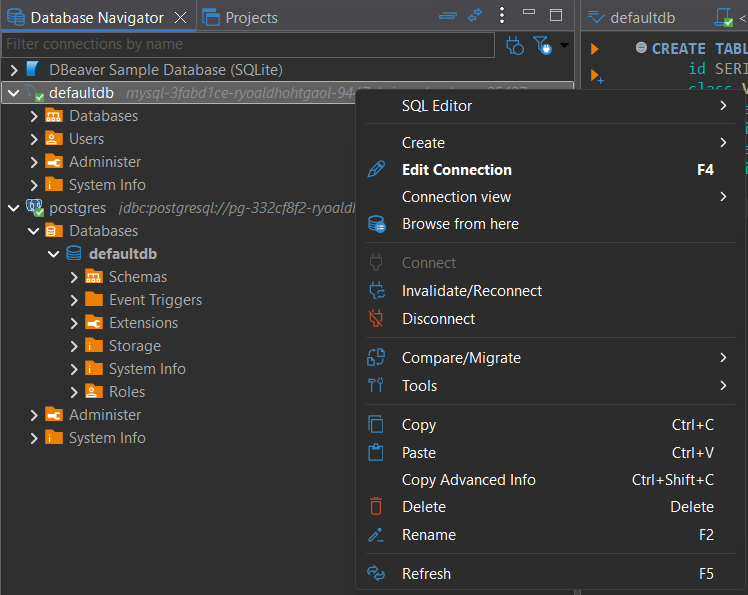

4. Pilih new script


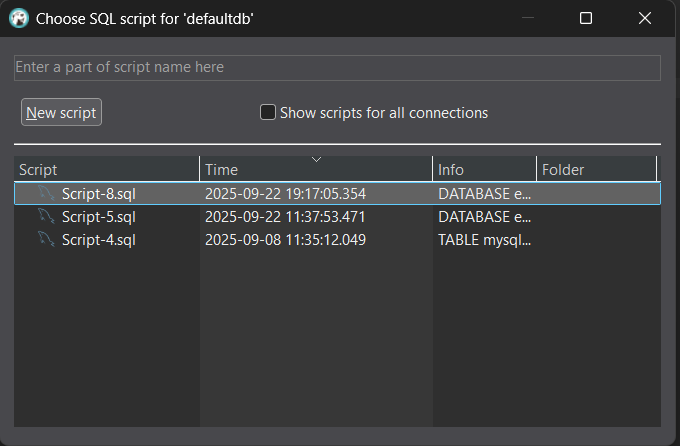

5. Masukkan SQL script untuk membuat database baru bernama ecoli_db

```python
CREATE DATABASE ecoli_db;
USE ecoli_db;

CREATE TABLE ecoli (
    id_protein VARCHAR(20) PRIMARY KEY,
    feature1 FLOAT,
    feature2 FLOAT,
    feature3 FLOAT,
    feature4 FLOAT,
    feature5 FLOAT,
    feature6 FLOAT,
    feature7 FLOAT,
    class_label VARCHAR(10)
);





6. Setelah SQL query di execute, maka akan muncul tabel baru bernama ecoli. Klik kanan pada tabel lalu pilih import data

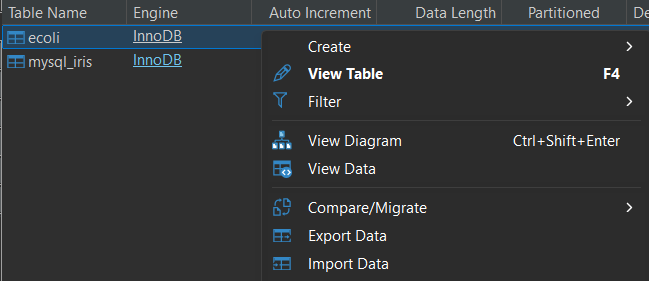

7. Pada import source pilih CSV → browse file ecoli.csv. Lalu lakukan mapping kolom → pastikan sesuai:

- id_protein → id_protein

- feature1–feature7 → kolom float

- class_label → class_label

Lalu klik Next → Process. Maka data ototmatis Masuk ke tabel

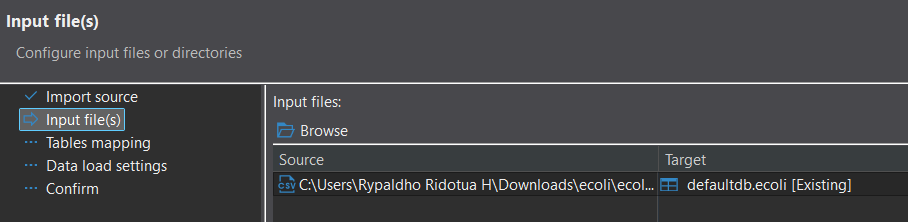

8. Setelah menyimpan di database MySQL selanjutnya kita akan menampilkan data dalam scatter plot menggunakan PCA (2 dimensi). Kita harus menarik data dari MySQL, melakukan PCA dan Melakukan Poting

9. Kita akan melakukan koneksi ke MySQL. Sebelum itu, pastikan sudah menginstall dependensi:



In [ ]:
pip install pandas pymysql scikit-learn imbalanced-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 971.6 kB/s eta 0:00:00


10. Sebelum kita melakukan koneksi, kita akan menupload ca.pem di google drive agar bisa digunakan sebagai koneksi dengan SSL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
ssl_path = "/content/drive/MyDrive/Colab Notebooks/ca.pem"  # sesuaikan jika beda folder



11. Selanjutnya kita lakukan koneksi ke Aiven MySQL menggunakan code berikut


In [ ]:
from sqlalchemy import create_engine
import pandas as pd

# isi dengan kredensial Aiven
user = "avnadmin"
password = "AVNS_RObduoJ-JUKEQFeviFf"
host = "mysql-3fabd1ce-ryoaldhohtgaol-9447.d.aivencloud.com"
port = 25427
database = "defaultdb"

# buat koneksi
engine = create_engine(
    f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}",
    connect_args={'ssl': {'ca': ssl_path}}
)

# test query
df = pd.read_sql("SELECT * FROM ecoli LIMIT 5;", engine)
print(df)


   id_protein  feature1  feature2  feature3  feature4  feature5  feature6  \
0   AAS_ECOLI      0.44      0.52      0.48       0.5      0.43      0.47   
1   AAT_ECOLI      0.49      0.29      0.48       0.5      0.56      0.24   
2  ACEA_ECOLI      0.07      0.40      0.48       0.5      0.54      0.35   
3  ACEK_ECOLI      0.56      0.40      0.48       0.5      0.49      0.37   
4  ACKA_ECOLI      0.59      0.49      0.48       0.5      0.52      0.45   

   feature7 class_label  
0      0.54          im  
1      0.35          cp  
2      0.44          cp  
3      0.46          cp  
4      0.36          cp  


12. Sebelum PCA, kita pastikan terlebih dahulu struktur tabel ecoli yang ada pada database aivem

In [ ]:
# cek struktur tabel ecoli
import pandas as pd

# ambil info tabel
df_info = pd.read_sql("DESCRIBE ecoli;", engine)
print("=== Struktur tabel ecoli ===")
print(df_info)

# cek 5 baris pertama data
df_sample = pd.read_sql("SELECT * FROM ecoli LIMIT 5;", engine)
print("\n=== Contoh data ===")
print(df_sample)


=== Struktur tabel ecoli ===
         Field         Type Null  Key Default Extra
0   id_protein  varchar(20)   NO  PRI    None      
1     feature1        float  YES         None      
2     feature2        float  YES         None      
3     feature3        float  YES         None      
4     feature4        float  YES         None      
5     feature5        float  YES         None      
6     feature6        float  YES         None      
7     feature7        float  YES         None      
8  class_label  varchar(10)  YES         None      

=== Contoh data ===
   id_protein  feature1  feature2  feature3  feature4  feature5  feature6  \
0   AAS_ECOLI      0.44      0.52      0.48       0.5      0.43      0.47   
1   AAT_ECOLI      0.49      0.29      0.48       0.5      0.56      0.24   
2  ACEA_ECOLI      0.07      0.40      0.48       0.5      0.54      0.35   
3  ACEK_ECOLI      0.56      0.40      0.48       0.5      0.49      0.37   
4  ACKA_ECOLI      0.59      0.49      0.48  

13. Setelah mengetahui kolom mana yang numerik (float) dan kolom mana yang label (kelas target), baru kita jalankan sippet untuk menampilkan visual data dalam scatter plot menggunakan PCA (2dimensi)

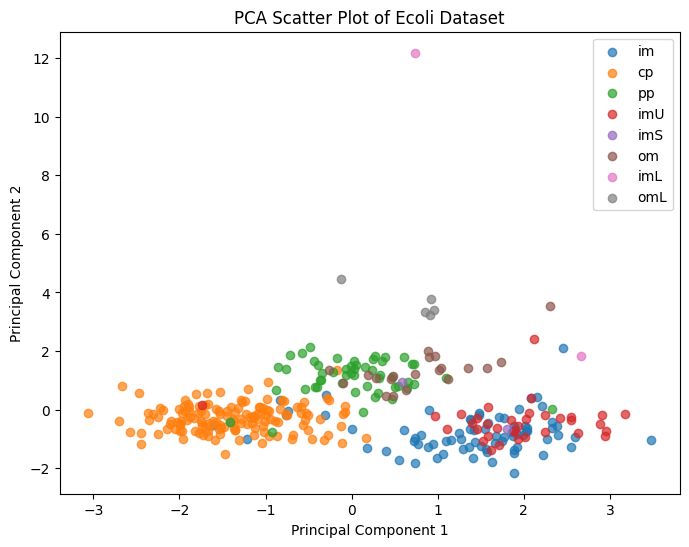

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ambil seluruh data
df = pd.read_sql("SELECT * FROM ecoli;", engine)

# pisahkan fitur numerik dan label
X = df[['feature1','feature2','feature3','feature4','feature5','feature6','feature7']]
y = df['class_label']

# normalisasi dulu biar PCA lebih stabil
X_scaled = StandardScaler().fit_transform(X)

# lakukan PCA ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# bikin DataFrame hasil PCA
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['class_label'] = y

# plotting
plt.figure(figsize=(8,6))
for label in df_pca['class_label'].unique():
    subset = df_pca[df_pca['class_label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, alpha=0.7)

plt.title("PCA Scatter Plot of Ecoli Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


Pembahasan dari hasil PCA:
1. Apa yang terjadi saat PCA dilakukan
  - PCA (Principal Component Analysis) mengambil semua variabel numerik dalam tabel ecoli lalu mengubahnya menjadi kombinasi linier yang disebut principal components.

  - Komponen pertama (PC1) memuat variasi data paling besar. Komponen kedua (PC2) memuat variasi terbesar berikutnya yang ortogonal terhadap PC1.

  - Jadi ketika kita memplot PC1 vs PC2 dalam scatter plot, kita sedang melihat representasi 2D dari data berdimensi banyak, dengan dua sumbu yang paling “informatif” dalam menjelaskan perbedaan antar sampel.

2. Hasil awal (tanpa label warna)
  - Scatter plot biasanya akan terlihat sebagai kumpulan titik tersebar di bidang PC1–PC2.

  - Pola yang muncul bisa:
    - Cluster rapat: berarti ada kesamaan struktur antar sampel.
    - Sebaran menyebar: berarti variasi tinggi dalam data.
    - Outlier: titik yang jauh dari kerumunan lain → indikasi anomali atau data unik.

3. Penjelasan tipikal pada dataset ecoli


> (Karena dataset ecoli memang klasik dalam bioinformatika untuk klasifikasi lokasi protein, struktur PCA biasanya begini:)



- PC1 sering memisahkan sampel berdasarkan sifat biologis utama (misalnya perbedaan lokasi membran).

- PC2 menambahkan informasi variasi tambahan yang lebih kecil (misalnya perbedaan halus antar kelas).

- Jika kita warnai berdasarkan kolom class (lokasi protein), biasanya akan terlihat cluster sebagian overlap:

  - Beberapa kelas jelas terpisah (misalnya cp dengan im).

  - Sebagian lain overlap karena fitur numeriknya mirip.

14. Selanjutnya kita akan melakukan penyeimbangan data menggunakan ADASYN. Karena dataset ecoli ini cenderung imbalanced antar kelas, kita bisa pakai ADASYN (Adaptive Synthetic Sampling). Tetapi Pada dataset Ecoli, ADASYN gagal dijalankan karena distribusi kelas sangat timpang dan tidak ada cukup tetangga dari mayoritas. Solusinya saya gunakan SMOTE untuk menghasilkan balancing yang valid. Berikut Code nya:

In [18]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X = df.drop(columns=['id_protein', 'class_label'])
y = df['class_label']

print("Distribusi awal:", Counter(y))

smote = SMOTE(random_state=42, k_neighbors=1)
X_res, y_res = smote.fit_resample(X, y)

print("Distribusi setelah SMOTE:", Counter(y_res))


Distribusi awal: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})
Distribusi setelah SMOTE: Counter({'im': 143, 'cp': 143, 'pp': 143, 'imU': 143, 'imS': 143, 'om': 143, 'imL': 143, 'omL': 143})


Berikut snippet lengkap untuk balancing dengan SMOTE lalu plot PCA (2 dimensi):

Distribusi awal: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})
Distribusi setelah SMOTE: Counter({'im': 143, 'cp': 143, 'pp': 143, 'imU': 143, 'imS': 143, 'om': 143, 'imL': 143, 'omL': 143})


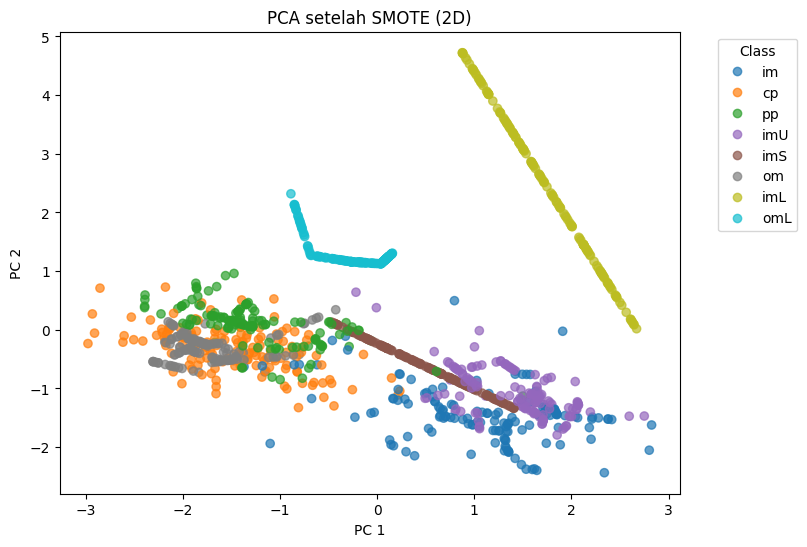

In [21]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

# --- 1. Pisahkan fitur dan label ---
X = df.drop(columns=['id_protein', 'class_label'])
y = df['class_label']

print("Distribusi awal:", Counter(y))

# --- 2. Terapkan SMOTE ---
smote = SMOTE(random_state=42, k_neighbors=1)
X_res, y_res = smote.fit_resample(X, y)

print("Distribusi setelah SMOTE:", Counter(y_res))

# --- 3. Standarisasi sebelum PCA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

# --- 4. PCA ke 2 dimensi ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- 5. Plot hasil ---
plt.figure(figsize=(8,6))

# Factorize agar warna sesuai class
labels, uniques = pd.factorize(y_res)
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', alpha=0.7)

plt.title("PCA setelah SMOTE (2D)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

# Legend: convert Index → list
plt.legend(handles=scatter.legend_elements()[0],
           labels=uniques.tolist(),
           title="Class",
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


### Hasil visualisasi:

- Setiap titik mewakili satu sampel (baik asli maupun sintetis dari SMOTE).

- Warna = kelas (class_label).

- Setelah SMOTE, jumlah titik antar kelas jadi lebih seimbang → cluster minoritas jadi lebih terlihat jelas.